# Import Necessary Libraries


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.graph_objs as go
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential 
from keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
import os
import glob
import json
import joblib

from numpy.random import seed
seed(42)

# Training Function for All Datasets


In [ ]:
def train_model_for_dataset(dataset_name, data_path, models_dir, metrics_dir, epochs=10, batch_size=64):
    """
    Train models for a given dataset and save models and metrics.
    
    Parameters:
    - dataset_name: Name of the dataset (e.g., 'AAPL')
    - data_path: Path to the CSV file
    - models_dir: Directory to save models
    - metrics_dir: Directory to save metrics
    - epochs: Number of training epochs (default: 10)
    - batch_size: Batch size for training (default: 64)
    """
    print(f"\n{'='*60}")
    print(f"Training models for {dataset_name}")
    print(f"{'='*60}\n")
    
    # Load dataset
    df = pd.read_csv(data_path)
    df['Date'] = pd.to_datetime(df['Date'])
    df['year'] = df['Date'].dt.year
    df['month'] = df['Date'].dt.month
    df['Open Price Change'] = df['Open'].diff()
    
    # Prepare data
    open_price = df.loc[:, 'Open'].to_numpy()
    open_price = open_price.reshape(-1, 1)
    
    # Split data (70% train, 10% validation, 20% test)
    train_size = int(len(open_price) * 0.7)
    valid_size = int(len(open_price) * 0.1)
    
    train_set = open_price[:train_size]
    valid_set = open_price[train_size:train_size + valid_size]
    test_set = open_price[train_size + valid_size:]
    
    # Initialize scalers
    sc = MinMaxScaler(feature_range=(0, 1))
    sc_valid = MinMaxScaler(feature_range=(0, 1))
    sc_test = MinMaxScaler(feature_range=(0, 1))
    
    train_set_scaled = sc.fit_transform(train_set)
    valid_set_scaled = sc_valid.fit_transform(valid_set)
    test_set_scaled = sc_test.fit_transform(test_set)
    
    # Generate sequences
    def generate_data(data, window_size_input=300):
        X = []
        y = []
        for i in range(window_size_input, len(data)):
            X_data = data[i - window_size_input:i, 0]
            y_data = data[i, 0]
            X.append(X_data)
            y.append(y_data)
        return np.array(X), np.array(y)
    
    WINDOW_SIZE = 300
    
    X_train, y_train = generate_data(train_set_scaled, WINDOW_SIZE)
    X_valid, y_valid = generate_data(valid_set_scaled, WINDOW_SIZE)
    
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))
    
    # Build and train LSTM model
    print(f"Training LSTM model for {dataset_name}...")
    model_1 = Sequential()
    model_1.add(LSTM(256, return_sequences=False, input_shape=(X_train.shape[1], 1)))
    model_1.add(Dense(128))
    model_1.add(Dense(64))
    model_1.add(Dense(1))
    model_1.compile(optimizer='adam', loss='mean_squared_error')
    
    hist = model_1.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
    print(f"LSTM training completed for {dataset_name}")
    
    # Train ensemble Ridge models
    print(f"Training Ridge ensemble models for {dataset_name}...")
    pred_price_train = model_1.predict(X_train, verbose=0)
    y_train_reshaped = y_train.reshape(len(y_train), 1)
    
    # Model 2
    y_2_train = y_train_reshaped - pred_price_train
    model_2 = Ridge()
    X_train_flat = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]))
    model_2.fit(X_train_flat, y_2_train)
    y_2_pred = model_2.predict(X_train_flat).reshape(-1, 1)
    pred_price_train += y_2_pred
    
    # Model 3
    y_3_train = y_train_reshaped - pred_price_train
    model_3 = Ridge()
    model_3.fit(X_train_flat, y_3_train)
    y_3_pred = model_3.predict(X_train_flat).reshape(-1, 1)
    pred_price_train += y_3_pred
    
    # Model 4
    y_4_train = y_train_reshaped - pred_price_train
    model_4 = Ridge()
    model_4.fit(X_train_flat, y_4_train)
    y_4_pred = model_4.predict(X_train_flat).reshape(-1, 1)
    pred_price_train += y_4_pred
    
    # Calculate training MSE
    train_mse = mean_squared_error(pred_price_train, y_train_reshaped)
    print(f"Training MSE for {dataset_name}: {train_mse}")
    
    # Validation predictions
    X_valid_reshaped = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))
    price_prediction = model_1.predict(X_valid_reshaped, verbose=0)
    
    X_valid_flat = np.reshape(X_valid_reshaped, (X_valid_reshaped.shape[0], X_valid_reshaped.shape[1]))
    
    y_2_valid = model_2.predict(X_valid_flat).reshape(-1, 1)
    y_3_valid = model_3.predict(X_valid_flat).reshape(-1, 1)
    y_4_valid = model_4.predict(X_valid_flat).reshape(-1, 1)
    
    price_prediction_valid = price_prediction + y_2_valid + y_3_valid + y_4_valid
    price_prediction_valid = sc_valid.inverse_transform(price_prediction_valid)
    
    zeros = np.zeros([WINDOW_SIZE])
    price_prediction_full = np.concatenate((zeros, price_prediction_valid.flatten()), axis=None)
    
    # Calculate validation MSE
    valid_mse = mean_squared_error(valid_set, price_prediction_full)
    print(f"Validation MSE for {dataset_name}: {valid_mse}")
    
    # Save models
    print(f"Saving models for {dataset_name}...")
    os.makedirs(models_dir, exist_ok=True)
    
    # Save LSTM model
    lstm_model_path = os.path.join(models_dir, f"{dataset_name}_lstm.h5")
    model_1.save(lstm_model_path)
    
    # Save Ridge models
    joblib.dump(model_2, os.path.join(models_dir, f"{dataset_name}_ridge_2.joblib"))
    joblib.dump(model_3, os.path.join(models_dir, f"{dataset_name}_ridge_3.joblib"))
    joblib.dump(model_4, os.path.join(models_dir, f"{dataset_name}_ridge_4.joblib"))
    
    # Save scalers
    joblib.dump(sc, os.path.join(models_dir, f"{dataset_name}_scaler_train.joblib"))
    joblib.dump(sc_valid, os.path.join(models_dir, f"{dataset_name}_scaler_valid.joblib"))
    joblib.dump(sc_test, os.path.join(models_dir, f"{dataset_name}_scaler_test.joblib"))
    
    # Save metrics
    print(f"Saving metrics for {dataset_name}...")
    os.makedirs(metrics_dir, exist_ok=True)
    
    metrics = {
        "dataset_name": dataset_name,
        "training_mse": float(train_mse),
        "validation_mse": float(valid_mse),
        "train_samples": int(len(train_set)),
        "valid_samples": int(len(valid_set)),
        "test_samples": int(len(test_set)),
        "window_size": WINDOW_SIZE,
        "epochs": epochs,
        "batch_size": batch_size,
        "training_history": {
            "final_loss": float(hist.history['loss'][-1]),
            "loss_values": [float(x) for x in hist.history['loss']]
        }
    }
    
    metrics_path = os.path.join(metrics_dir, f"{dataset_name}_metrics.json")
    with open(metrics_path, 'w') as f:
        json.dump(metrics, f, indent=2)
    
    print(f"Completed training for {dataset_name}!\n")
    
    return metrics

# Train Models for All Datasets


In [ ]:
# Define paths (relative to notebook location: src/backend/train/)
data_dir = "../models/data"
models_dir = "../models"  # Save models to src/backend/models/
metrics_dir = "../models/metrics"  # Save metrics to src/backend/models/metrics/

# Get all CSV files in the data directory
csv_files = glob.glob(os.path.join(data_dir, "*.csv"))

if not csv_files:
    print(f"No CSV files found in {data_dir}")
    print("Please check the data directory path.")
else:
    print(f"Found {len(csv_files)} dataset(s) to train:")
    for f in csv_files:
        print(f"  - {os.path.basename(f)}")
    
    # Train models for each dataset
    all_metrics = {}
    for csv_file in csv_files:
        # Extract dataset name from filename (e.g., "AAPL.csv" -> "AAPL")
        dataset_name = os.path.splitext(os.path.basename(csv_file))[0]
        
        try:
            metrics = train_model_for_dataset(
                dataset_name=dataset_name,
                data_path=csv_file,
                models_dir=models_dir,
                metrics_dir=metrics_dir,
                epochs=10,
                batch_size=64
            )
            all_metrics[dataset_name] = metrics
        except Exception as e:
            print(f"Error training {dataset_name}: {str(e)}")
            import traceback
            traceback.print_exc()
    
    print(f"\n{'='*60}")
    print("Training Summary")
    print(f"{'='*60}")
    for dataset_name, metrics in all_metrics.items():
        print(f"{dataset_name}:")
        print(f"  Training MSE: {metrics['training_mse']:.6f}")
        print(f"  Validation MSE: {metrics['validation_mse']:.6f}")
        print()
    
    print(f"All models saved to: {models_dir}")
    print(f"All metrics saved to: {metrics_dir}")

,Date,Open,High,Low,Close,Adj Close,Volume,year,month,Open Price Change
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100323,469033600,1980,12,NaN
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.095089,175884800,1980,12,-0.006138
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.088110,105728000,1980,12,-0.008929
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090291,86441600,1980,12,0.002232
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092908,73449600,1980,12,0.003349


In [13]:
appl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10409 entries, 0 to 10408
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               10409 non-null  datetime64[ns]
 1   Open               10409 non-null  float64       
 2   High               10409 non-null  float64       
 3   Low                10409 non-null  float64       
 4   Close              10409 non-null  float64       
 5   Adj Close          10409 non-null  float64       
 6   Volume             10409 non-null  int64         
 7   year               10409 non-null  int32         
 8   month              10409 non-null  int32         
 9   Open Price Change  10408 non-null  float64       
dtypes: datetime64[ns](1), float64(6), int32(2), int64(1)
memory usage: 732.0 KB


Text(0.5, 1.0, 'Volume trend over time')

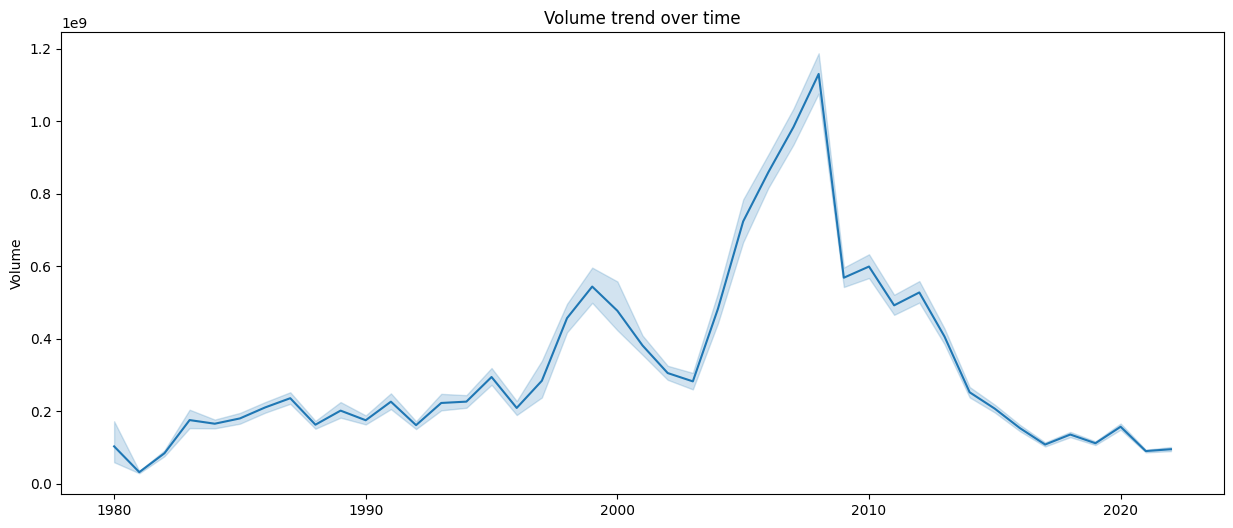

In [8]:
plt.figure(figsize=(15, 6))
sns.lineplot(y = appl['Volume'], x= appl['year'])
plt.xlabel("")
plt.title("Volume trend over time")

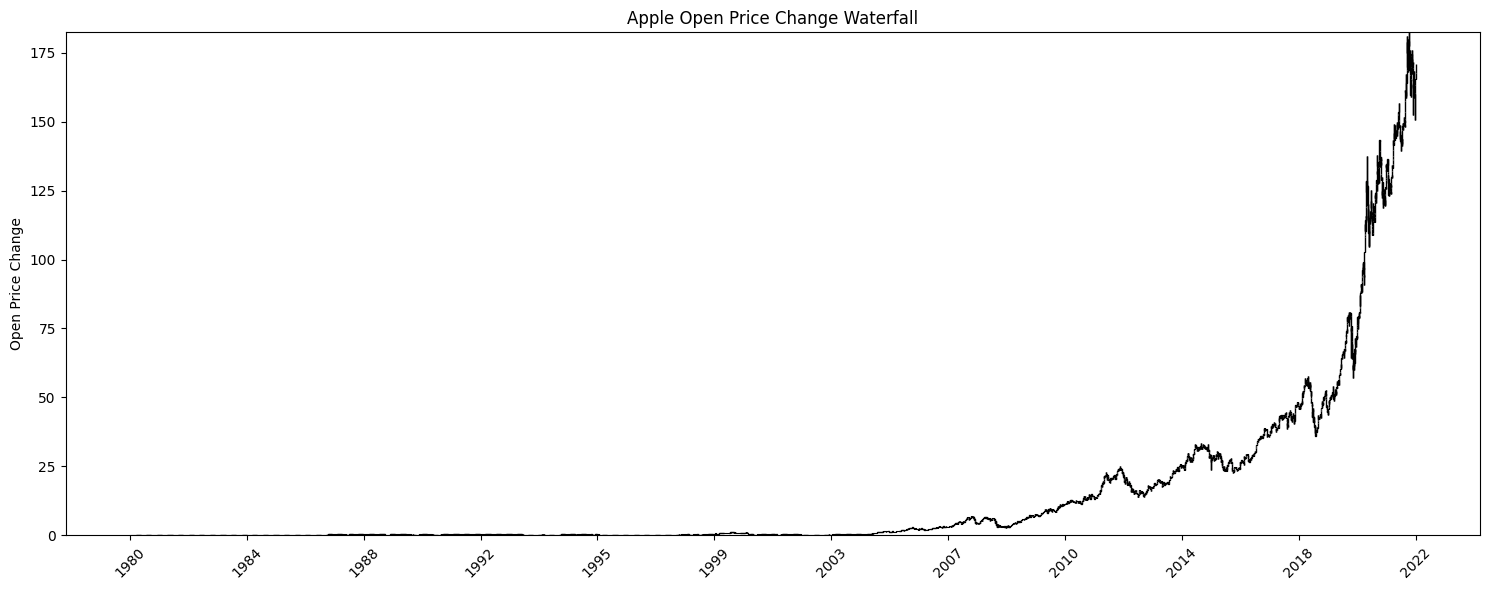

In [17]:
from matplotlib.ticker import MaxNLocator

data = appl.dropna(subset=['Open Price Change']).reset_index()
date_ticks = data['Date']

changes = data['Open Price Change'].values
x = np.arange(len(changes))

cumulative = np.zeros(len(changes) + 1)
cumulative[1:] = np.cumsum(changes)
bar_color = np.array(['green'] * len(changes))

fig, ax = plt.subplots(figsize=(15, 6))

for i in range(len(changes)):
    ax.bar(
        x[i], 
        changes[i], 
        bottom=cumulative[i], 
        color=bar_color[i], 
        edgecolor='black', 
        width=0.5,
    )
    if i > 0:
        ax.plot([x[i-1], x[i]], [cumulative[i], cumulative[i]], color='black', linewidth=0.75)

ax.plot([x[0], x[-1]], [cumulative[0], cumulative[-1]], alpha=0)

ax.set_title('Apple Open Price Change Waterfall')
ax.set_xlabel('')
ax.set_ylabel('Open Price Change')
ax.xaxis.set_major_locator(MaxNLocator(integer=True, nbins=12))

years = data['year'].values
label_indices = np.linspace(0, len(years) - 1, min(12, len(years)), dtype=int)
ax.set_xticks(label_indices)
ax.set_xticklabels([years[i] for i in label_indices], rotation=45)

plt.tight_layout()
plt.show()

## Predicting Opening Value


### Prepare Train Data


In [21]:
open_price=appl.loc[:,'Open'].to_numpy()
open_price = open_price.reshape(-1, 1)
train_set = open_price[:7000]
valid_set = open_price[7000:8000]
test_set = open_price[8000:]

sc = MinMaxScaler(feature_range=(0, 1))
sc_valid = MinMaxScaler(feature_range=(0, 1))
sc_test = MinMaxScaler(feature_range=(0, 1))

train_set_scaled = sc.fit_transform(train_set)
valid_set_scaled = sc_valid.fit_transform(valid_set)
test_set_scaled = sc_test.fit_transform(test_set)

def generate_data(data, window_size_input = 300):
    X = []
    y = []
    for i in range(window_size_input, len(data)):
        # Get the data 
        X_data = data[i - window_size_input : i, 0]
        y_data = data[i, 0]
        X.append(X_data)
        y.append(y_data)
    return np.array(X), np.array(y)

WINDOW_SIZE_SEARCH = 300

X_train, y_train = generate_data(train_set_scaled, WINDOW_SIZE_SEARCH)
X_valid, y_valid = generate_data(valid_set_scaled, WINDOW_SIZE_SEARCH)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))

### Making Models


In [24]:
model_1_open = Sequential()

model_1_open.add(LSTM(256, return_sequences=False, input_shape= (X_train.shape[1], 1)))
model_1_open.add(Dense(128))
model_1_open.add(Dense(64))
model_1_open.add(Dense(1))

model_1_open.compile(optimizer = 'adam', loss = 'mean_squared_error',)

hist = model_1_open.fit(X_train, y_train, epochs = 10, batch_size = 64, verbose = 2)

Epoch 1/10
105/105 - 67s - 642ms/step - loss: 7.9314e-04
Epoch 2/10
105/105 - 69s - 653ms/step - loss: 7.4699e-05
Epoch 3/10
105/105 - 67s - 639ms/step - loss: 8.6174e-05
Epoch 4/10
105/105 - 65s - 616ms/step - loss: 8.3073e-05
Epoch 5/10
105/105 - 66s - 627ms/step - loss: 9.1717e-05
Epoch 6/10
105/105 - 68s - 645ms/step - loss: 1.1988e-04
Epoch 7/10
105/105 - 67s - 642ms/step - loss: 7.7210e-05
Epoch 8/10
105/105 - 68s - 646ms/step - loss: 7.3993e-05
Epoch 9/10
105/105 - 69s - 656ms/step - loss: 6.5574e-05
Epoch 10/10
105/105 - 69s - 655ms/step - loss: 6.7671e-05


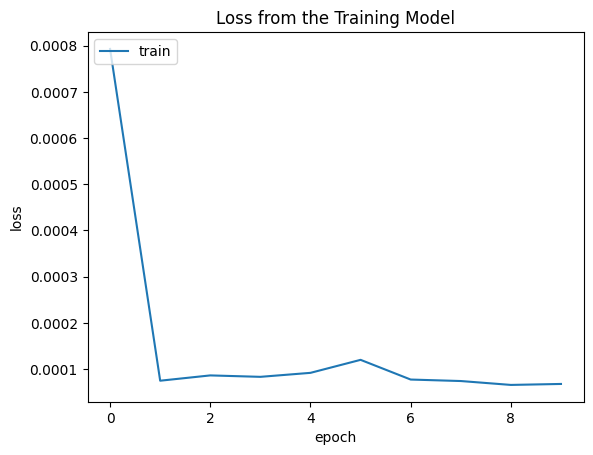

In [25]:
plt.plot(hist.history['loss'])
plt.title('Loss from the Training Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc = 'upper left')
plt.show()

In [ ]:
pred_price_train = model_1_open.predict(X_train)

210/210 ━━━━━━━━━━━━━━━━━━━━ 24s 115ms/step


In [30]:
y_train=y_train.reshape(len(y_train),1)
y_2_train=y_train-pred_price_train

In [33]:
model_2_open = Ridge()
X_train_flat = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]))
model_2_open.fit(X_train_flat, y_2_train)
y_2_pred = model_2_open.predict(X_train_flat).reshape(-1, 1)
pred_price_train += y_2_pred

In [35]:
y_3_train = y_train - pred_price_train
model_3_open = Ridge()
X_train_flat = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]))
model_3_open.fit(X_train_flat, y_3_train)
y_3_pred = model_3_open.predict(X_train_flat).reshape(-1, 1)
pred_price_train += y_3_pred

In [37]:
y_4_train = y_train - pred_price_train
model_4_open = Ridge()
X_train_flat = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]))
model_4_open.fit(X_train_flat, y_4_train)
y_4_pred = model_4_open.predict(X_train_flat).reshape(-1, 1)
pred_price_train += y_4_pred

In [38]:
print(mean_squared_error(pred_price_train,y_train))

2.839506520889105e-05


### Prepare Validation Data


In [ ]:
X_valid_reshaped = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))
price_prediction = model_1_open.predict(X_valid_reshaped)

# Flatten X_valid for Ridge models
X_valid_flat = np.reshape(X_valid_reshaped, (X_valid_reshaped.shape[0], X_valid_reshaped.shape[1]))

# Get predictions from ensemble models
y_2_valid = model_2_open.predict(X_valid_flat).reshape(-1, 1)
y_3_valid = model_3_open.predict(X_valid_flat).reshape(-1, 1)
y_4_valid = model_4_open.predict(X_valid_flat).reshape(-1, 1)

# Combine predictions
price_prediction_valid = price_prediction + y_2_valid + y_3_valid + y_4_valid

# Inverse transform if necessary (assuming sc_valid was used for y scaling)
price_prediction_valid = sc_valid.inverse_transform(price_prediction_valid)

# Add initial zeros as padding to match expected output length
zeros = np.zeros([WINDOW_SIZE_SEARCH])
price_prediction = np.concatenate((zeros, price_prediction_valid.flatten()), axis=None)

22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step


In [41]:
price_error = mean_squared_error(valid_set, price_prediction)
print("Price error on the validation set : ", price_error)

Price error on the validation set :  6.978926879100945


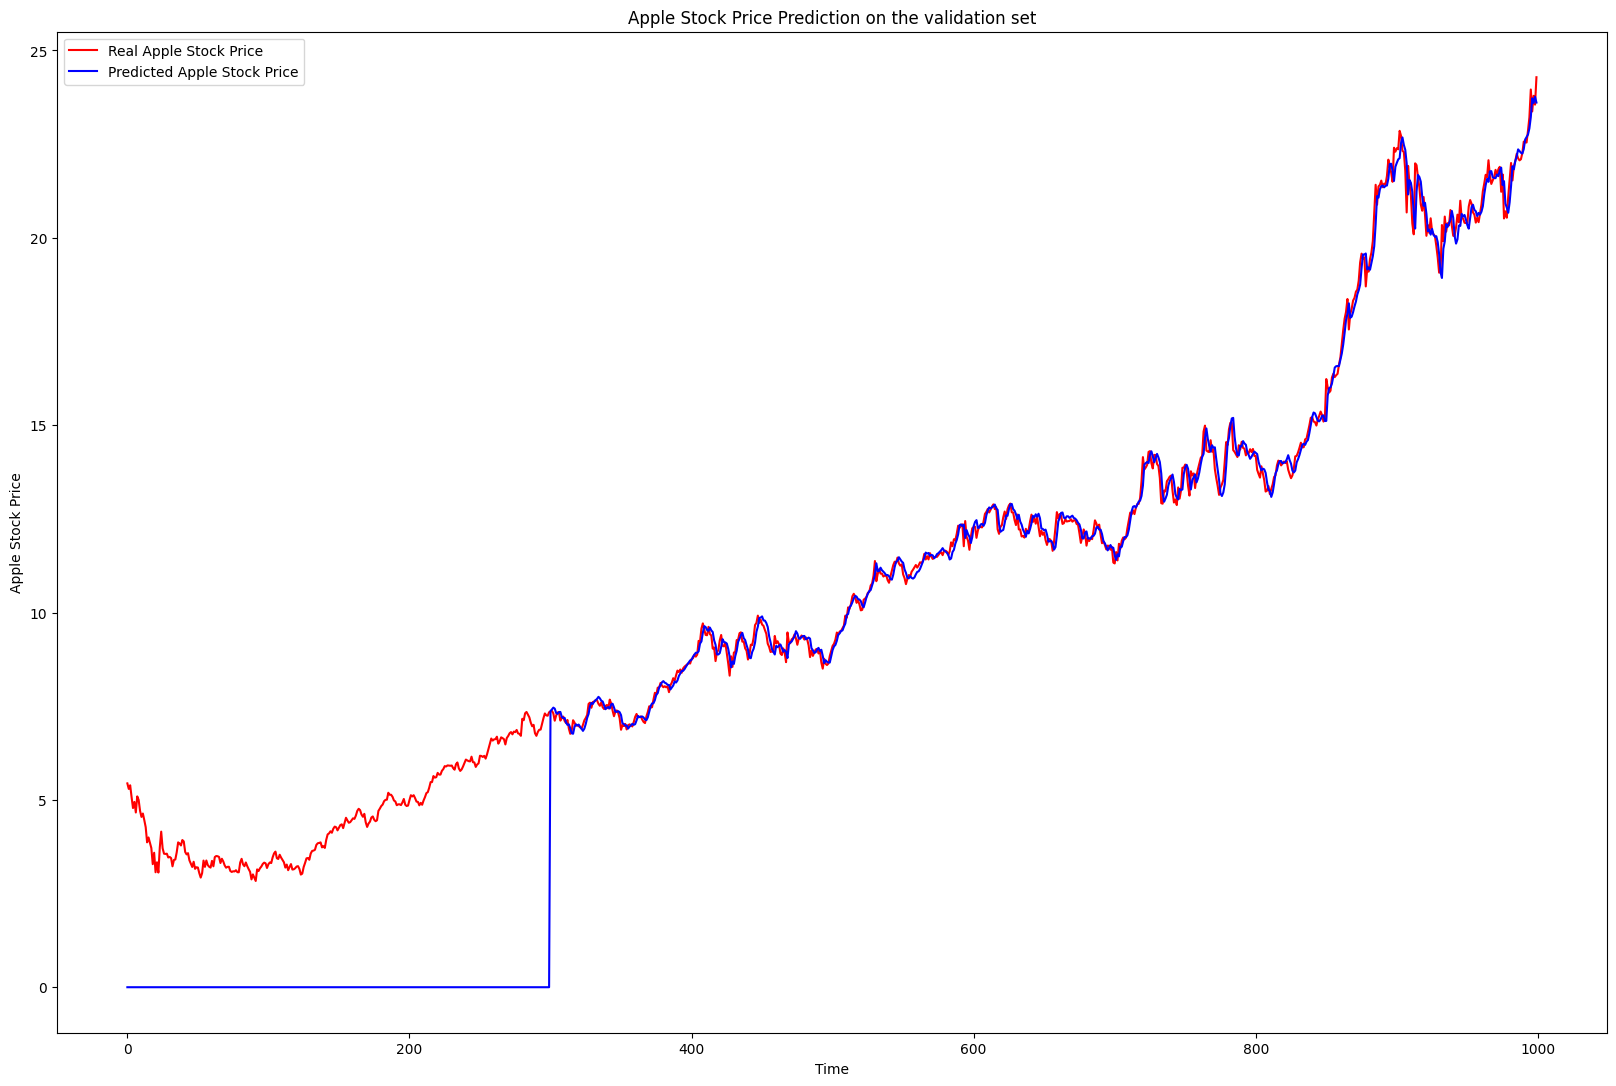

In [44]:
plt.figure(figsize=(20,13))
plt.plot(valid_set, color='red',label='Real Apple Stock Price')
plt.plot(price_prediction, color='blue',label='Predicted Apple Stock Price')
plt.title('Apple Stock Price Prediction on the validation set')
plt.xlabel('Time')
plt.ylabel('Apple Stock Price')
plt.legend()
plt.show()